In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data visualization
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from matplotlib.pyplot import plot

# Preprocessing
from sklearn import preprocessing

# ML Packages
#from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow as tf


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
test_data 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


## EDA

In [4]:
nan_count = train_data.isna().sum()
nan_count

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
# Checking the different values available for a feature
unique_values_HomePlanet = train_data['HomePlanet'].unique()
unique_values_HomePlanet_count = train_data[train_data['HomePlanet']=="Europa"]
print(f"HomePlanet Unique Values: {unique_values_HomePlanet}, HomePlanet Europa Count: {unique_values_HomePlanet_count.shape[0]}" )

unique_values_CryoSleep = train_data['CryoSleep'].unique()
unique_values_CryoSleep_count = train_data[train_data['CryoSleep']=="True"]
print(f"CryoSleep Unique Values: {unique_values_CryoSleep}, CryoSleep yes Count: {unique_values_CryoSleep_count.shape[0]}" )


HomePlanet Unique Values: ['Europa' 'Earth' 'Mars' nan], HomePlanet Europa Count: 2131
CryoSleep Unique Values: [False True nan], CryoSleep yes Count: 0


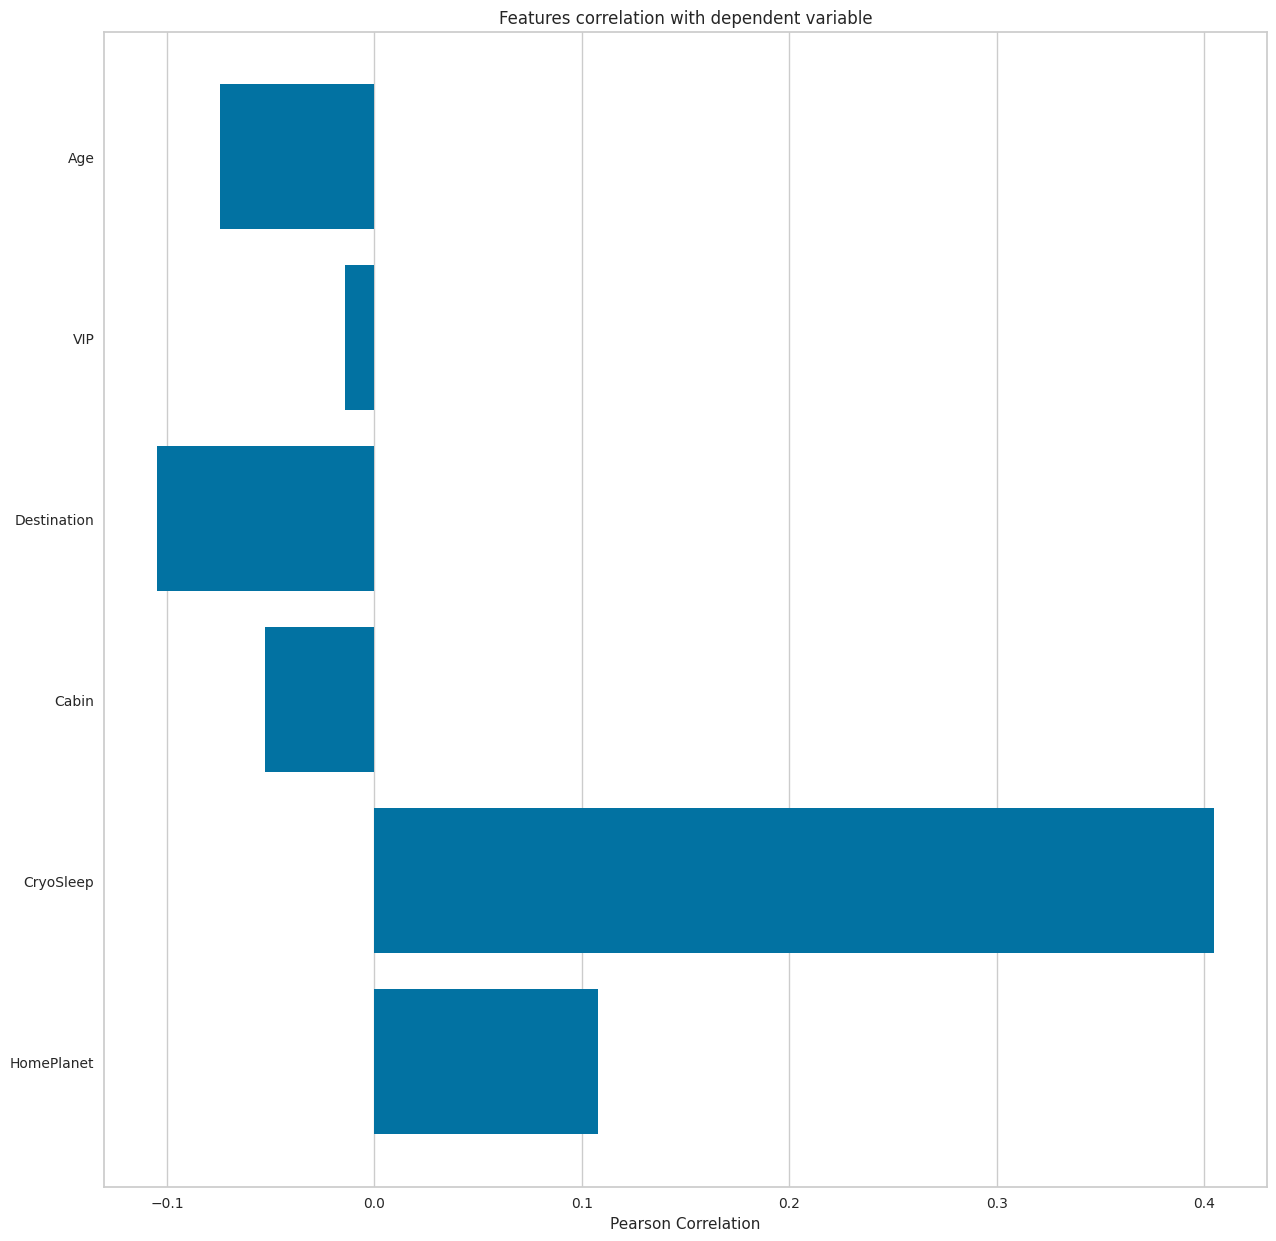

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [6]:
from yellowbrick.target import FeatureCorrelation

# Converting categorical data in numberical data
label_encoder = preprocessing.LabelEncoder()
train_data['HomePlanet'] = label_encoder.fit_transform(train_data['HomePlanet'])

label_encoder = preprocessing.LabelEncoder()
train_data['CryoSleep'] = label_encoder.fit_transform(train_data['CryoSleep'])

label_encoder = preprocessing.LabelEncoder()
train_data['VIP'] = label_encoder.fit_transform(train_data['VIP'])

label_encoder = preprocessing.LabelEncoder()
train_data['Cabin'] = label_encoder.fit_transform(train_data['Cabin'])

label_encoder = preprocessing.LabelEncoder()
train_data['Destination'] = label_encoder.fit_transform(train_data['Destination'])

# Filling
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].mean())


feature_names = ['HomePlanet','CryoSleep','Cabin','Destination','VIP','Age']

X, y = train_data[feature_names], train_data['Transported']

# List of feature names
features = np.array(feature_names)

# Instantiating the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize'] = (15,15)

# Fitting data into the visualizer
visualizer.fit(X,y)
visualizer.show()

In [7]:
# Similar transformation in test dataset
label_encoder = preprocessing.LabelEncoder()
test_data['HomePlanet'] = label_encoder.fit_transform(test_data['HomePlanet'])

label_encoder = preprocessing.LabelEncoder()
test_data['CryoSleep'] = label_encoder.fit_transform(test_data['CryoSleep'])

label_encoder = preprocessing.LabelEncoder()
test_data['Destination'] = label_encoder.fit_transform(test_data['Destination'])

label_encoder = preprocessing.LabelEncoder()
test_data['VIP'] = label_encoder.fit_transform(test_data['VIP'])

label_encoder = preprocessing.LabelEncoder()
test_data['Cabin'] = label_encoder.fit_transform(test_data['Cabin'])

## Model

In [8]:
y = train_data['Transported']
features = ['HomePlanet','CryoSleep','VIP']
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

#model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=90000)
model = GradientBoostingClassifier(n_estimators=10000, learning_rate=0.5, max_depth=3, random_state=42)
model.fit(X,y)


GradientBoostingClassifier(learning_rate=0.5, n_estimators=10000,
                           random_state=42)

## Predicting whether the passengers were successfully transported

In [9]:
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId':test_data.PassengerId,'Transported':predictions})
output.to_csv('submission.csv',index=False)
print('Submission Sucessfully Saved')

Submission Sucessfully Saved


In [10]:
output

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False
